<a href="https://colab.research.google.com/github/mojtabaSefidi/Machine-Learning-with-Graphs/blob/main/MLG_Final_Project_100k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !unzip ml-100k.zip
# !pip uninstall jupyter
# !pip install jupyter

## Install Essential Packages

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
!pip install -q torch_geometric
!pip install -q torch-sparse==0.6.13
!pip install -q torch_scatter


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 KB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Install Essential Libraries

In [3]:

import torch
import networkx as nx
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, SAGEConv, global_add_pool
from torch_geometric.data import HeteroData
from torch_geometric import transforms
from torch_geometric.loader import LinkNeighborLoader
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.metrics import classification_report

In [4]:
from numpy.random import seed
from tensorflow import keras
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from torch_geometric.loader import LinkNeighborLoader
import numpy as np
import pandas as pd
import torch
import random
import time

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
sn.set()

def plot_confusion_matrix(confusion_matrix, title='', cmap ='Greens'):
    df = pd.DataFrame(confusion_matrix, range(len(confusion_matrix)), range(len(confusion_matrix)))
    plt.figure(figsize=(6,4))
    if title == '' :
        plt.title('Confusion Matrix')
    else:
        plt.title('Confusion Matrix for' + ' ' + title)
    sn.set(font_scale=1)
    sn.heatmap(df, annot=True, annot_kws={"size": 12},fmt='.0f',cmap=cmap) # font size
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

def save_evaluation_details(report, df, duration, title):
  row = []
  for item in list(report.values()):
    if type(item) == dict:
      row.extend(item.values())
    else:
      row.append(item)
  
  row.append(duration)
  row.append(title)
  return df.append(pd.DataFrame([row], columns=df.columns.values), ignore_index=True)

In [7]:
def plot_history(list_train_rmse, list_train_mse, list_val_rmse, list_val_mse, n_epochs, title):
    
    plt.figure(figsize=(18,8),linewidth = 7, edgecolor="whitesmoke")    
    n = n_epochs
    
    plt.plot(list(range(1, n_epochs+1)), list_train_rmse, color='red', marker=".")
    plt.plot(list(range(1, n_epochs+1)), list_train_mse, color='black' ,marker=".")
    
    plt.plot(list(range(1, n_epochs+1)), list_val_rmse, color='blue') 
    plt.plot(list(range(1, n_epochs+1)), list_val_mse, color='purple')
    
    plt.legend(['Train RMSE', 'Train MSE','Validation RMSE','Validation MSE'])
    plt.grid(True)
    
    plt.gca().set_ylim(0.5,3.5)
    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    title = 'RMSE & MSE for Train & Validation dataset in ' + title
    plt.suptitle(title, size=16, y=0.927)
    plt.show()

def plot_history_overall(list_train_rmse, list_train_mse, list_val_rmse, list_val_mse, list_test_rmse, list_test_mse):
    
    plt.figure(figsize=(18,8),linewidth = 7, edgecolor="whitesmoke")    
    n = n_epochs
    
    plt.plot(['U1 Splits','U2 Splits','U3 Splits','U4 Splits'], list_train_rmse, color='red',marker=".")
    plt.plot(['U1 Splits','U2 Splits','U3 Splits','U4 Splits'], list_train_mse, color='black' ,marker=".")
    
    plt.plot(['U1 Splits','U2 Splits','U3 Splits','U4 Splits'], list_val_rmse, color='blue')  
    plt.plot(['U1 Splits','U2 Splits','U3 Splits','U4 Splits'], list_val_mse, color='purple')
    
    plt.plot(['U1 Splits','U2 Splits','U3 Splits','U4 Splits'], list_test_rmse, color='green')  
    plt.plot(['U1 Splits','U2 Splits','U3 Splits','U4 Splits'], list_test_mse, color='brown')
    
    plt.legend(['Train RMSE', 'Train MSE','Validation RMSE','Validation MSE', 'Test RMSE','Test MSE'])
    plt.grid(True)
    
    plt.gca().set_ylim(0.5,3.5)
    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    title = 'RMSE & MSE for Train/Validation/Test dataset in one view'
    plt.suptitle(title, size=16, y=0.927)
    plt.show()

## Read the Dataset

In [8]:
# from ogb.graphproppred import PygGraphPropPredDataset
# from torch_geometric.loader import DataLoader

# dataset = PygGraphPropPredDataset(name = 'ogbg-molhiv') 

# split_idx = dataset.get_idx_split() 
# train_data_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True)
# valiation_data_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=True)
# test_data_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=True)

In [9]:
# !unzip /content/MovieLens1M.zip

In [10]:
# movies_df = pd.read_csv('/content/ml-100k/u.item', sep='|', engine='python', encoding="latin-1",
#                         names = ['MovieID', 'Movie Title', 'Release Date', 'video release date','IMDbURL',
#                                  'Unknown','Action','Adventure','Animation', 'Childrens','Comedy',
#                                  'Crime','Documentary','Drama','Fantasy', 'Film-Noir','Horror',
#                                  'Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'])

# rating_df = pd.read_csv('/content/ml-100k/u.data', sep='\t', engine='python', encoding="latin-1",
#                         names=['UserID','MovieID','Rating','Timestamp'])

# users_df = pd.read_csv('/content/ml-100k/u.user', sep='|', engine='python', encoding="latin-1",
#                        names=['UserID','Gender','Age','Occupation','Zipcode'])

# movies_df.to_csv('/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/movies_df.csv', index=False)
# rating_df.to_csv('/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/rating_df.csv', index=False)
# users_df.to_csv('/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/users_df.csv', index=False)

In [11]:
# geners = np.array(['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama',
#                    'Fantasy', 'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western'], dtype=str)

# values = list(range(0, len(geners)))
# geners2vec = dict(zip(geners, values))

# def extract_geners(text, sep='|'):
#   return text.split(sep)

# def geners2vector(df_geners, maper):
#   result = np.zeros((len(df_geners),len(maper)), dtype='int8')
#   for index, text in enumerate(df_geners):
#     geners = extract_geners(text)
#     for gener in geners:
#       result[index][maper.get(gener)] = 1
  
#   return result

In [12]:
# def year_extractor(text):
#   return text[text.rfind('(')+1:text.rfind(')')]

def add_average_rating(rating_df, movies_df, Movie_id_col='MovieID', rating_col='Rating'):
  
  rating_avg = rating_df.groupby(Movie_id_col).mean()[rating_col].round(4).to_dict()
  result = [] 
  for id in movies_df[Movie_id_col]:
    result.append(rating_avg.get(id, 0))
  movies_df['Average Rating'] = result
  return movies_df

# Occupation_mapper = { 0: "other", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
#                      4: "college/grad student",5: "customer service", 6: "doctor/health care",
#                      7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student",
#                      11: "lawyer", 12: "programmer", 13: "retired", 14: "sales/marketing",
#                      15: "scientist", 16: "self-employed", 17: "technician/engineer",
#                      18: "tradesman/craftsman", 19: "unemployed", 20: "writer"}

# def code2Occupation(occupation_col, mapper):
#   return occupation_col.map(mapper)


# def extract_user_feature(users_df):
#   scaler = StandardScaler()
#   age = scaler.fit_transform(users_df[['Age']])
  
#   encoder = OneHotEncoder(handle_unknown='ignore')
#   occupation = encoder.fit_transform(users_df[['Occupation']]).toarray()
#   features = np.hstack((users_df[['Gender']], age, occupation))
#   return torch.from_numpy(features).to(torch.float)

# def extract_movie_feature(movies_df, mapper):
#   scaler = StandardScaler()
#   numerical = scaler.fit_transform(movies_df[['year',	'averge_rating']])
  
#   categorical = geners2vector(movies_df['Genres'], mapper)
#   features = np.hstack((numerical, categorical))
#   return torch.from_numpy(features).to(torch.float)

def Timestamp2Date(timestamp):
  return datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

def add_age_group(df, age_col='Age'):
  bins= [0,20,25,39,60,110]
  labels = ['Teenage','Young Adult','Adult', 'Older Adult','Old']
  df['AgeGroup'] = pd.cut(df[age_col], bins=bins, labels=labels, right=False)
  return df

def find_unknowns(movies_df, title_col='Movie Title', movie_id_col='MovieID'):
  unknown_movies = movies_df[movies_df[title_col]=='unknown'][movie_id_col]
  return unknown_movies

def remove_unknows(df, list_unknown_movies, movie_id_col='MovieID'):
  return df[~df[movie_id_col].isin(list_unknown_movies)]


In [13]:
def build_AE(encoding_dim = 8, input_shape= 24):

  input_dim = Input(shape = (input_shape, ))

  encoded1 = Dense(16, activation = 'relu')(input_dim)
  encoded2 = Dense(encoding_dim, activation = 'relu')(encoded1)

  decoded1 = Dense(16, activation = 'relu')(encoded2)
  decoded2 = Dense(input_shape, activation = 'relu')(decoded1)


  autoencoder = Model(inputs = input_dim, outputs = decoded2)
  encoder = Model(inputs = input_dim, outputs = encoded2)

  autoencoder.compile(optimizer = keras.optimizers.Adadelta(learning_rate=0.05), loss = 'binary_crossentropy')
  print(autoencoder.summary())
  return autoencoder, encoder

def train_reduce_AE(AE, encoder, features, epochs=50, batch_size=16):
  print('---------------------------------------Trainig of AE Sarts...')
  AE.fit(features, features, epochs=epochs, batch_size=batch_size, shuffle = True, verbose=0)
  print('--------------------------------------- Dimensionality Reduction Sarts...')
  return encoder.predict(features)

In [14]:
class PreProcess_Dfs():
  def __init__(self,
               movies_df_path,
               users_df_path,
               ratings_df_path,
               train_df_path,
               test_df_path,
               ):
    
    self.movies_df = pd.read_csv(movies_df_path)
    self.ratings_df_all = pd.read_csv(ratings_df_path)
    self.users_df = pd.read_csv(users_df_path)
    self.train_df_path = train_df_path
    self.test_df_path = test_df_path
    self.list_unknown_movies = find_unknowns(self.movies_df)
  
  def preprocess_movies_df(self):
    self.movies_df = remove_unknows(self.movies_df, self.list_unknown_movies)
    self.movies_df.drop(['video release date', 'IMDbURL'], axis=1, inplace=True)
    self.movies_df['Release Date'] = pd.to_datetime(self.movies_df['Release Date'])
    self.movies_df['Release Year'] = self.movies_df['Release Date'].dt.year
    self.movies_df['Release Month'] = self.movies_df['Release Date'].dt.month
    self.movies_df['Release Day'] = self.movies_df['Release Date'].dt.strftime('%j').apply(int)
    self.movies_df = self.movies_df.sort_values(by=['Release Date']).reset_index(drop=True)
    self.movies_df = add_average_rating(self.ratings_df_all, self.movies_df)

  def preprocess_users_df(self):
    self.users_df = add_age_group(self.users_df)

  def preprocess_rating_df(self, ratings_df, extract_details=False):
    ratings_df = remove_unknows(ratings_df, self.list_unknown_movies)
    if extract_details:
      ratings_df.loc[:,'Timestamp'] = ratings_df.loc[:,'Timestamp'].apply(Timestamp2Date)
      ratings_df.sort_values(by='Timestamp', inplace=True)
      ratings_df.reset_index(drop=True, inplace=True)

      ratings_df.loc[:,'Timestamp'] = pd.to_datetime(ratings_df.loc[:,'Timestamp'])
      ratings_df.loc[:,'Year'] = ratings_df.loc[:,'Timestamp'].dt.year
      ratings_df.loc[:,'Month'] = ratings_df.loc[:,'Timestamp'].dt.month
      ratings_df.loc[:,'Weekday'] = ratings_df.loc[:,'Timestamp'].dt.weekday
      ratings_df.loc[:,'Hour'] = ratings_df.loc[:,'Timestamp'].dt.hour
      ratings_df.loc[:,'DayofYear'] = ratings_df.loc[:,'Timestamp'].dt.strftime('%j')
    
    return ratings_df
  
  def generate_train_validation(self, factor=0.5):
    df = pd.read_csv(self.train_df_path, sep='\t', engine='python', encoding="latin-1",
                            names=['UserID','MovieID','Rating','Timestamp'])
    train_df = pd.DataFrame(columns=['UserID','MovieID','Rating','Timestamp'])
    validation_df = pd.DataFrame(columns=['UserID','MovieID','Rating','Timestamp'])
    for movie_id in df['MovieID'].unique():
      df_temp = df[df['MovieID']== movie_id]
      df_temp = df_temp.sort_values('Timestamp')
      lenght_window = len(df_temp)
      if lenght_window != 1:
        cut = round(lenght_window * factor)  
        train_df = pd.concat([train_df, df_temp.iloc[:cut,:]])
        validation_df = pd.concat([validation_df, df_temp.iloc[cut:,:]])
      elif (lenght_window != 1 and factor == 0.5): 
        if len(train_df) > len(validation_df):
          validation_df = pd.concat([validation_df, df_temp])
        elif len(train_df) < len(validation_df):
          train_df = pd.concat([train_df, df_temp])
        else:
          if random.random() >= (1-factor):
            train_df = pd.concat([train_df, df_temp])
          else:
            validation_df = pd.concat([validation_df, df_temp])
      else:
          if random.random() >= (1-factor):
            train_df = pd.concat([train_df, df_temp])
          else:
            validation_df = pd.concat([validation_df, df_temp])

    train_df = self.preprocess_rating_df(train_df)
    validation_df = self.preprocess_rating_df(validation_df)
    return train_df.reset_index(drop=True), validation_df.reset_index(drop=True)

  def generate_test(self):
    test_df = pd.read_csv(self.test_df_path, sep='\t', engine='python', encoding="latin-1",
                          names=['UserID','MovieID','Rating','Timestamp'])
    test_df = self.preprocess_rating_df(test_df)
    return test_df.reset_index(drop=True)

  def finalize_dfs(self,
                 train_rating_df, validation_rating_df, test_rating_df,
                 user_id_col='UserID', movie_id_col='MovieID'
                 ):
  
    unique_user_id = self.users_df['UserID'].unique()
    unique_user_id = pd.DataFrame(data={
        'UserID': unique_user_id,
        'mappedID': pd.RangeIndex(len(unique_user_id))
        })
    userid_mapper = dict(zip(unique_user_id.iloc[:,0], unique_user_id.iloc[:,-1]))
    
    # print("1. Mapping UserID to consecutive values... ")

    unique_movie_id = self.movies_df['MovieID'].unique()
    unique_movie_id = pd.DataFrame(data={
        'MovieID': unique_movie_id,
        'mappedID': pd.RangeIndex(len(unique_movie_id))
        })
    movieid_mapper = dict(zip(unique_movie_id.iloc[:,0], unique_movie_id.iloc[:,-1]))
    # print("2. Mapping MovieID to consecutive values... ")

    self.users_df['UserID'] = self.users_df['UserID'].map(userid_mapper)
    self.users_df = self.users_df.sort_values(by='UserID').reset_index(drop=True)
    self.movies_df['MovieID'] =  self.movies_df['MovieID'].map(movieid_mapper)
    self.movies_df = self.movies_df.sort_values(by='MovieID').reset_index(drop=True)
    train_rating_df['UserID'] = train_rating_df['UserID'].map(userid_mapper)
    train_rating_df['MovieID'] =  train_rating_df['MovieID'].map(movieid_mapper)
    validation_rating_df['UserID'] = validation_rating_df['UserID'].map(userid_mapper)
    validation_rating_df['MovieID'] =  validation_rating_df['MovieID'].map(movieid_mapper)
    test_rating_df['UserID'] = test_rating_df['UserID'].map(userid_mapper)
    test_rating_df['MovieID'] =  test_rating_df['MovieID'].map(movieid_mapper)

    self.users_df = self.users_df.sort_values(by=user_id_col).reset_index(drop=True)
    self.movies_df = self.movies_df.sort_values(by=movie_id_col).reset_index(drop=True)
    train_rating_df = train_rating_df.sort_values(by=[user_id_col, movie_id_col]).reset_index(drop=True)
    validation_rating_df = validation_rating_df.sort_values(by=[user_id_col, movie_id_col]).reset_index(drop=True)
    test_rating_df = test_rating_df.sort_values(by=[user_id_col, movie_id_col]).reset_index(drop=True)
    return train_rating_df, validation_rating_df, test_rating_df
  
  def extract_user_feature(self):
    scaler = StandardScaler()
    age = scaler.fit_transform(self.users_df[['Age']])
    
    encoder = OneHotEncoder(handle_unknown='ignore')
    categorical_df = encoder.fit_transform(self.users_df[['Occupation', 'Gender']]).toarray()
    features = np.hstack((categorical_df, age))
    return features

  def extract_movie_feature(self, exclude_cols=['MovieID','Movie Title', 'Release Date']):
    movies_df = self.movies_df.drop(exclude_cols, axis=1)
    scaler = StandardScaler()
    movies_df[['Release Year', 'Release Month', 'Average Rating', 'Release Day']] = scaler.fit_transform(
        movies_df[['Release Year', 'Release Month', 'Average Rating', 'Release Day']])
    features = movies_df.to_numpy()
    return features
  
  def PCA_DR(self, features, component=16):
    pca = PCA(component)
    return pca.fit_transform(features)
  
  def AE_DR(self, features, encoding_dim=16):
    AE, encoder = build_AE(encoding_dim = encoding_dim, input_shape= features.shape[-1])
    return train_reduce_AE(AE, encoder, features)

  def main(self, DR_Approach='PCA', split_factor=0.5):
    print('1. PreProcessing of Movies and users data-frames...')
    self.preprocess_movies_df()
    self.preprocess_users_df()

    print('2. Generate Train/ Validation/ Test data-frames...')
    train_df, validation_df = self.generate_train_validation(factor=split_factor)
    test_df = self.generate_test()
    
    print('3. PreProcessing of Train/ Validation/ Test data-frames...')
    train_df = self.preprocess_rating_df(train_df)
    validation_df = self.preprocess_rating_df(validation_df)
    test_df = self.preprocess_rating_df(test_df)
    
    print('4. Finalizing all data-frames...')
    train_df, validation_df, test_df = self.finalize_dfs(train_df, validation_df, test_df)
    
    print('5. Extract users & movies features...')
    user_features = self.extract_user_feature()
    movie_features = self.extract_movie_feature()

    if DR_Approach == 'PCA':
      print('6. Reduce dimensionality of features...')
      user_features = self.PCA_DR(user_features)
      movie_features = self.PCA_DR(movie_features)

    elif DR_Approach == 'AE':
      print('6. Reduce dimensionality of features...')
      user_features = self.AE_DR(user_features)
      movie_features = self.AE_DR(movie_features)

    print('------------ Finished ------------')
    return train_df, validation_df, test_df, user_features, movie_features

In [15]:
def extract_user_feature(users_df):
  scaler = StandardScaler()
  age = scaler.fit_transform(users_df[['Age']])
  
  encoder = OneHotEncoder(handle_unknown='ignore')
  categorical_df = encoder.fit_transform(users_df[['Occupation', 'Gender']]).toarray()
  features = np.hstack((categorical_df, age))
  return features

def extract_movie_feature(movies_df, exclude_cols):
  movies_df = movies_df.drop(exclude_cols, axis=1)
  scaler = StandardScaler()
  movies_df[['Release Year', 'Release Month', 'Average Rating', 'Release Day']] = scaler.fit_transform(
      movies_df[['Release Year', 'Release Month', 'Average Rating', 'Release Day']])
  features = movies_df.to_numpy()
  return features

In [16]:
class Build_graphs():
  def __init__(self,
               train_df,
               validation_df,
               test_df,
               ):
    
    self.train_df = train_df
    self.validation_df = validation_df
    self.test_df = test_df
  
  def generate_edge(self, rating_df, rating_threshold=0):

    graph_edges = [[],[]]
    edge_weight = []

    for userID, movieID, rating in rating_df[['UserID','MovieID','Rating']].itertuples(index=False):
      if rating >= rating_threshold:
        graph_edges[0].append(userID)
        graph_edges[1].append(movieID)
        edge_weight.append(rating)
      
      else:
        continue
    
    return torch.tensor(graph_edges, dtype=torch.long), torch.tensor(edge_weight, dtype=torch.float)

  def generate_hetero_dataset(self, data, movies_df, users_df, movie_feature, user_feature, edges, labels):
    dataset = HeteroData()

    dataset["user"].node_id = torch.tensor(users_df['UserID'].unique().astype(int), dtype=torch.int)
    dataset["movie"].node_id = torch.tensor(movies_df['MovieID'].unique().astype(int), dtype=torch.int)
    dataset["movie"].x = torch.tensor(movie_feature, dtype=torch.float)
    dataset["user"].x = torch.tensor(user_feature, dtype=torch.float)
    dataset["user", "rates", "movie"].edge_index = edges
    dataset["user", "rates", "movie"].edge_label_index = edges
    dataset["user", "rates", "movie"].edge_label = labels

    dataset = transforms.ToUndirected()(dataset)
    dataset = transforms.NormalizeFeatures()(dataset)
    return dataset
  
  def generate_data_loader(self, dataset):
    edge_label_index = dataset["user", "rates", "movie"].edge_label_index
    edge_label = dataset["user", "rates", "movie"].edge_label
    data_loader = LinkNeighborLoader(
        data=dataset,
        num_neighbors=[20, 10],
        neg_sampling_ratio=2.0,
        edge_label_index=(("user", "rates", "movie"), edge_label_index),
        edge_label=edge_label,
        batch_size=32,
        shuffle=True
        )
    return data_loader

  def main(self, movies_df, users_df, user_features, movie_features):
    
    print('1. Extract graph edges and edges labels...')
    graph_edges_train, label_train = self.generate_edge(self.train_df)
    graph_edges_validation, label_validation = self.generate_edge(self.validation_df)
    graph_edges_test, label_test = self.generate_edge(self.test_df)

    print('2. Generate Train/ Validation/ Test datasets...')
    train_dataset = self.generate_hetero_dataset(self.train_df, movies_df, users_df, movie_features, user_features, graph_edges_train, label_train)
    validation_dataset = self.generate_hetero_dataset(self.validation_df, movies_df, users_df, movie_features, user_features, graph_edges_validation, label_validation)
    test_dataset = self.generate_hetero_dataset(self.test_df, movies_df, users_df, movie_features, user_features, graph_edges_test, label_test)

    
    print('3. Convert Train/ Validation/ Test datasets to form of data-loders...')
    train_loader = self.generate_data_loader(train_dataset)
    validation_loader = self.generate_data_loader(validation_dataset)
    test_loader = self.generate_data_loader(test_dataset)
    
    print('------------ Finished ------------')
    return train_dataset, train_loader, validation_loader, test_loader


In [17]:
# (validation_dataset["user", "rates", "movie"].edge_index).max(), validation_dataset["movie"].x.size(0)

In [18]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.conv5 = SAGEConv(hidden_channels, hidden_channels)
        self.conv6 = SAGEConv(hidden_channels, hidden_channels)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)
        x = x.relu()
        x = self.conv6(x, edge_index)
        return x



class Classifier(torch.nn.Module):
    def forward(self, x_user, x_movie, edge_label_index):

        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]

        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

class Model(torch.nn.Module):
    
    def __init__(self, data, hidden_channels, user_features_dim, movie_features_dim):
        super().__init__()


        self.user_lin = torch.nn.Linear(user_features_dim, hidden_channels)
        self.movie_lin = torch.nn.Linear(movie_features_dim, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)

        self.gnn = GNN(hidden_channels)

        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()
    
    def forward(self, data):
        x_dict = {
          "user": self.user_lin(data["user"].x) + self.user_emb(data["user"].node_id),
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        } 

        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            data["user", "rates", "movie"].edge_label_index,
        )
        return pred
        
# model = Model(data=train_dataset , hidden_channels=32, user_features_dim=8, movie_features_dim=8)
# model

In [19]:
# del user_autoencoder, user_encoder, movie_autoencoder, movie_encoder, pca

In [20]:
class Learning_Evaluation(torch.nn.Module):
    def __init__(
        self,
        model,
        learning_rate=0.01,
        best_results=[np.Inf, np.Inf, np.Inf, np.Inf, np.Inf],
        ):
      
      super().__init__()
      self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      self.model = model.to(self.device)
      self.optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate)
      self.criterion = torch.nn.MSELoss()
      self.best_results = best_results
    
    def train(self, data_loader):
        self.model.train()

        for data in data_loader:
            data.to(self.device)
            out = self.model(data)
            label = data["user", "rates", "movie"].edge_label
            loss = self.criterion(out, label)
            # loss = F.mse_loss(pred, ground_truth)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

    def train_model(self, train_data_loader, validation_data_loader, n_epochs=15, best_model_saving_path='best_model.pth'):
      
      list_train_mse, list_train_rmse, list_validation_rmse, list_validation_mse = [], [], [], []
      print('Train and Evaluation started...')
      for epoch in range(1, n_epochs+1):
          self.train(train_data_loader)
          
          # train_auc, train_loss = self.evaluate(train_data_loader)
          _ , _ , train_rmse_loss, train_mse_loss = self.evaluate(train_data_loader)
          list_train_mse.append(train_mse_loss)
          list_train_rmse.append(train_rmse_loss)
          
          _ , _ , validation_rmse_loss, validation_mse_loss = self.evaluate(validation_data_loader)
          list_validation_mse.append(validation_mse_loss)
          list_validation_rmse.append(validation_rmse_loss)
          
          if self.best_results[-2] > validation_mse_loss :
            self.best_results[0] = epoch
            self.best_results[1], self.best_results[2] = train_mse_loss, train_rmse_loss
            self.best_results[-2], self.best_results[-1] = validation_mse_loss, validation_rmse_loss
            torch.save(self.model, best_model_saving_path)


          # print(f'Epoch: {epoch:03d}, Train ROC-AUC: {train_auc:.4f}, Train Loss: {train_loss:.4f}, Validation ROC-AUC: {validation_auc:.4f}, Validation Loss: {validation_loss:.4f}')
          print(f'Epoch: {epoch:03d}, Train MSE: {train_mse_loss:.4f}, Train RMSE: {train_rmse_loss:.4f}, Validation MSE: {validation_mse_loss:.4f}, Validation RMSE: {validation_rmse_loss:.4f}')
      
      print('---------------------------------------------------')
      print('Train and Evaluation finished...')
      print(f'Best Results of the model : Epoch: {self.best_results[0]:03d}, Train RMSE: {self.best_results[2]:.4f}, Validation RMSE: {self.best_results[-1]:.4f}')
      print(f'Model weights restored from epoch: {self.best_results[0]:03d}')
      return list_train_mse, list_train_rmse, list_validation_rmse, list_validation_mse

    def evaluate(self, data_loder, best_model_path=None):
      self.model.eval()
      
      if not best_model_path is None:
        model = torch.load(best_model_path)
      else:
        model = self.model
      predicted = []
      labels = []
      for data in data_loder:
          with torch.no_grad():
              data.to(self.device)
              predicted.append(model(data))
              labels.append(data["user", "rates", "movie"].edge_label)

      predicted = torch.cat(predicted, dim=0).cpu().numpy()
      labels = torch.cat(labels, dim=0).cpu().numpy()
      rmse = mean_squared_error(labels, predicted, squared=False)
      mse = mean_squared_error(labels, predicted, squared=True)

      return labels, predicted, rmse, mse

      
      

In [24]:
list_datasets = [('u1.base', 'u1.test'),('u2.base', 'u2.test'),
                 ('u3.base', 'u3.test'),('u4.base', 'u4.test'),
                 ('u5.base', 'u5.test')
                 ]

DR_Approach=''
learning_rate=0.05
n_epochs = 30
hidden_channels=64
split_factor = 0.75

report_df = pd.DataFrame(columns=['precision_0','recall_0','f1-score_0','support_0',
                           'precision_1','recall_1','f1-score_1','support_1',
                           'accuracy', 'precision_macro','recall_macro','f1-score_macro','support_macro',
                           'precision_weighted','recall_weighted','f1-score_weighted','support_weighted', 'Duration', 'title'
                           ])

result_saving_path = '/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Results_Best_models/GraphSage_All_Feature.csv'

train_mse_all, train_rmse_all, validation_rmse_all, validation_mse_all, test_mse_all, test_rmse_all  = [], [], [], [], [], []
predictions, labels = [], []

--------------------- Working on split 1 started...
1) Pre-processing...
1. PreProcessing of Movies and users data-frames...
2. Generate Train/ Validation/ Test data-frames...
3. PreProcessing of Train/ Validation/ Test data-frames...
4. Finalizing all data-frames...
5. Extract users & movies features...
------------ Finished ------------
2) Convert to graph...
1. Extract graph edges and edges labels...
2. Generate Train/ Validation/ Test datasets...
3. Convert Train/ Validation/ Test datasets to form of data-loders...
------------ Finished ------------
3) Model Training...
Train and Evaluation started...
Epoch: 001, Train MSE: 1.8777, Train RMSE: 1.3703, Validation MSE: 1.7831, Validation RMSE: 1.3353
Epoch: 002, Train MSE: 1.7811, Train RMSE: 1.3346, Validation MSE: 1.7437, Validation RMSE: 1.3205
Epoch: 003, Train MSE: 1.7199, Train RMSE: 1.3115, Validation MSE: 1.6864, Validation RMSE: 1.2986
Epoch: 004, Train MSE: 1.6862, Train RMSE: 1.2985, Validation MSE: 1.5988, Validation RMSE

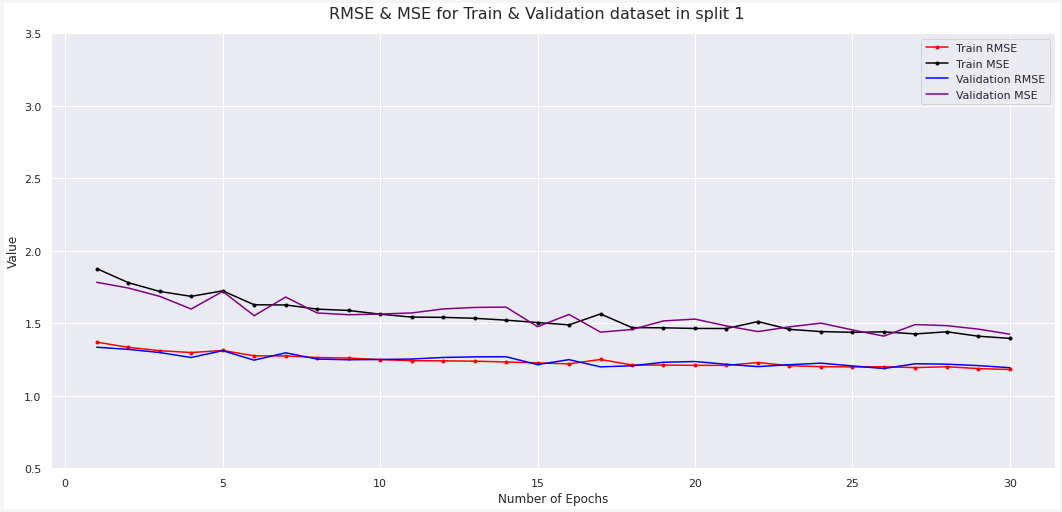


Test MSE = 1.686225414276123, Test RMSE = 1.298547387123108




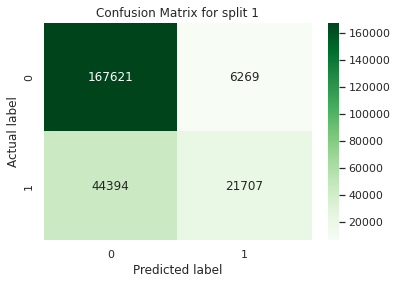


              precision    recall  f1-score   support

           0       0.79      0.96      0.87    173890
           1       0.78      0.33      0.46     66101

    accuracy                           0.79    239991
   macro avg       0.78      0.65      0.67    239991
weighted avg       0.79      0.79      0.76    239991


--------------------- Working on split 1 finished...
------------------------------------------------------------------------------------------------------
--------------------- Working on split 2 started...
1) Pre-processing...
1. PreProcessing of Movies and users data-frames...
2. Generate Train/ Validation/ Test data-frames...
3. PreProcessing of Train/ Validation/ Test data-frames...
4. Finalizing all data-frames...
5. Extract users & movies features...
------------ Finished ------------
2) Convert to graph...
1. Extract graph edges and edges labels...
2. Generate Train/ Validation/ Test datasets...
3. Convert Train/ Validation/ Test datasets to form of data-

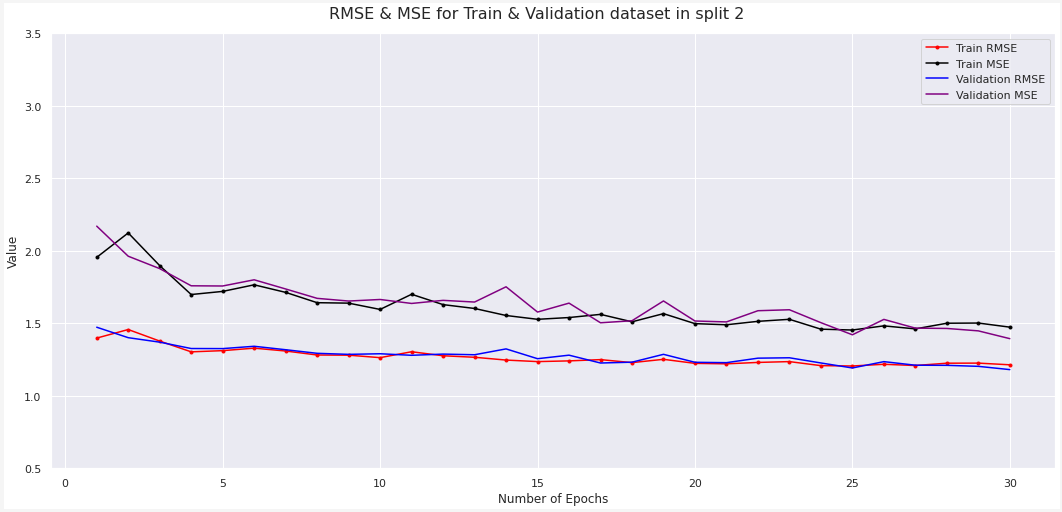


Test MSE = 1.8346599340438843, Test RMSE = 1.3544962406158447




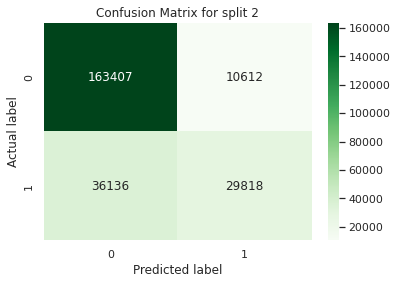


              precision    recall  f1-score   support

           0       0.82      0.94      0.87    174019
           1       0.74      0.45      0.56     65954

    accuracy                           0.81    239973
   macro avg       0.78      0.70      0.72    239973
weighted avg       0.80      0.81      0.79    239973


--------------------- Working on split 2 finished...
------------------------------------------------------------------------------------------------------
--------------------- Working on split 3 started...
1) Pre-processing...
1. PreProcessing of Movies and users data-frames...
2. Generate Train/ Validation/ Test data-frames...
3. PreProcessing of Train/ Validation/ Test data-frames...
4. Finalizing all data-frames...
5. Extract users & movies features...
------------ Finished ------------
2) Convert to graph...
1. Extract graph edges and edges labels...
2. Generate Train/ Validation/ Test datasets...
3. Convert Train/ Validation/ Test datasets to form of data-

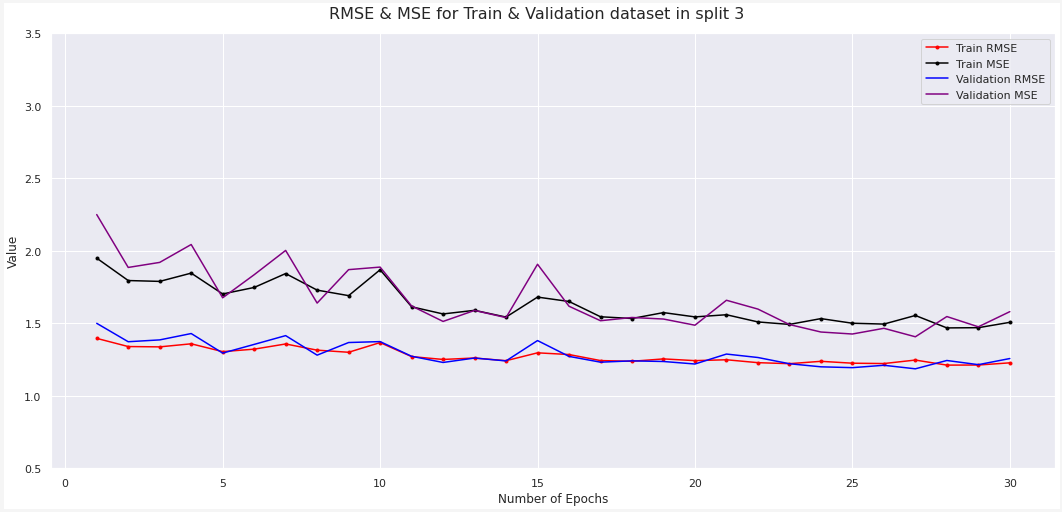


Test MSE = 1.805895447731018, Test RMSE = 1.3438360691070557




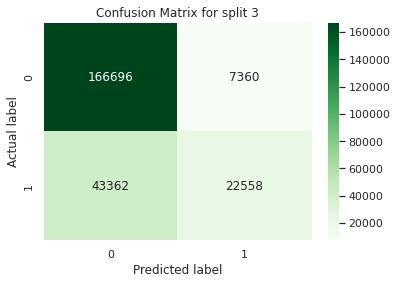


              precision    recall  f1-score   support

           0       0.79      0.96      0.87    174056
           1       0.75      0.34      0.47     65920

    accuracy                           0.79    239976
   macro avg       0.77      0.65      0.67    239976
weighted avg       0.78      0.79      0.76    239976


--------------------- Working on split 3 finished...
------------------------------------------------------------------------------------------------------
--------------------- Working on split 4 started...
1) Pre-processing...
1. PreProcessing of Movies and users data-frames...
2. Generate Train/ Validation/ Test data-frames...
3. PreProcessing of Train/ Validation/ Test data-frames...
4. Finalizing all data-frames...
5. Extract users & movies features...
------------ Finished ------------
2) Convert to graph...
1. Extract graph edges and edges labels...
2. Generate Train/ Validation/ Test datasets...
3. Convert Train/ Validation/ Test datasets to form of data-

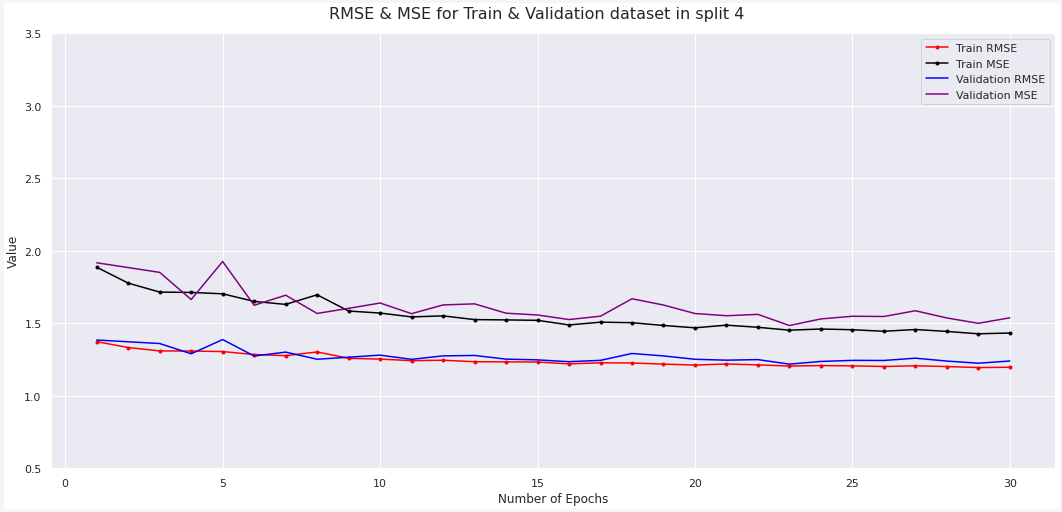


Test MSE = 1.7336616516113281, Test RMSE = 1.3166859149932861




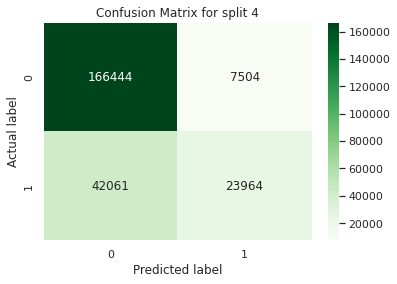


              precision    recall  f1-score   support

           0       0.80      0.96      0.87    173948
           1       0.76      0.36      0.49     66025

    accuracy                           0.79    239973
   macro avg       0.78      0.66      0.68    239973
weighted avg       0.79      0.79      0.77    239973


--------------------- Working on split 4 finished...
------------------------------------------------------------------------------------------------------
--------------------- Working on split 5 started...
1) Pre-processing...
1. PreProcessing of Movies and users data-frames...
2. Generate Train/ Validation/ Test data-frames...
3. PreProcessing of Train/ Validation/ Test data-frames...
4. Finalizing all data-frames...
5. Extract users & movies features...
------------ Finished ------------
2) Convert to graph...
1. Extract graph edges and edges labels...
2. Generate Train/ Validation/ Test datasets...
3. Convert Train/ Validation/ Test datasets to form of data-

In [ ]:


for i, data_pahts in enumerate(list_datasets):
    start = time.time()
    print('--------------------- Working on split %d started...' %(i+1))
    preprocessor = PreProcess_Dfs(movies_df_path = '/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/movies_df.csv',
                                  users_df_path = '/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/users_df.csv',
                                  ratings_df_path = '/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/rating_df.csv',
                                  train_df_path = '/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/'+ data_pahts[0] ,
                                  test_df_path = '/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/'+ data_pahts[0]
                                  )
    
    print('1) Pre-processing...')
    train_df, validation_df, test_df, user_features, movie_features = preprocessor.main(DR_Approach=DR_Approach, split_factor=split_factor)
    graph_generator = Build_graphs(train_df,
                                   validation_df,
                                   test_df)
    
    print('2) Convert to graph...')
    train_dataset, train_loader, validation_loader, test_loader = graph_generator.main(preprocessor.movies_df, preprocessor.users_df,
                                                                                       user_features, movie_features)
    print('3) Model Training...')
    model = Model(data=train_dataset , hidden_channels=hidden_channels,
                  user_features_dim=user_features.shape[-1],
                  movie_features_dim=movie_features.shape[-1])
    
    experiment = Learning_Evaluation(model, learning_rate=learning_rate)
    model_path = '/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Results_Best_models/best_model_all' + str(i+1) + '.pth'
    list_train_mse, list_train_rmse, list_validation_rmse, list_validation_mse = experiment.train_model(train_loader, validation_loader,
                                                                                                        n_epochs=n_epochs,
                                                                                                        best_model_saving_path=model_path)
    
    train_mse_all.append(list_train_mse)
    train_rmse_all.append(list_train_rmse)
    validation_rmse_all.append(list_validation_rmse)
    validation_mse_all.append(list_validation_mse)
    
    print('4) Model Evaluation...')
    results = experiment.evaluate(test_loader)
    labels.append(results[0])
    predictions.append(results[1]), 
    test_rmse_all.append(results[-2])
    test_mse_all.append(results[-1])

    title = 'split '+ str(i+1)
    
    print()
    plot_history(list_train_rmse, list_train_mse, list_validation_rmse, list_validation_mse, n_epochs, title)
    print()
    
    print(f'Test MSE = {results[-1]}, Test RMSE = {results[-2]}')
    print()

    l = np.where(results[0]>=3, 1, 0)
    p = np.where(results[1]>=3, 1, 0)
    print()
    plot_confusion_matrix(confusion_matrix(l, p), title=title, cmap ='Greens')
    print()
    print(classification_report(l, p))
    print()
    report = classification_report(l, p, output_dict=True)
    duration = time.time() - start
    report_df = save_evaluation_details(report, report_df, duration, title)

    report_df.to_csv(result_saving_path, index=False)

    print('--------------------- Working on split %d finished...' %(i+1))
    print('------------------------------------------------------------------------------------------------------')


In [ ]:
plot_history_overall(np.array(train_rmse_all).mean(axis=1),np.array(train_mse_all).mean(axis=1),
                     np.array(validation_rmse_all).mean(axis=1), np.array(validation_mse_all).mean(axis=1),
                     np.array(test_rmse_all), np.array(test_mse_all))